In [1]:
import os
#import pandas as pd
import numpy as np
import cv2
#from PIL import Image
import random
#import tensorflow as tf
#import re
import datetime
import io
#from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import pickle
#import string
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Conv2D, MaxPooling2D, Reshape, Dropout, BatchNormalization, Activation
from utils import score_prediction, generate_token_index, y_labels
%matplotlib inline

Using TensorFlow backend.


In [2]:
def normalize(image):
    # normalize
    (m, s) = cv2.meanStdDev(image)
    m = m[0][0]
    s = s[0][0]
    image = image - m
    image = image / s if s > 0 else image

    return image

In [3]:
target_token_index, num_decoder_tokens = generate_token_index()
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [5]:
dataset = pickle.load(open('../data_targhe/images.p', 'rb'))

In [7]:
dataset.keys()

dict_keys(['test', 'train', 'valid'])

In [9]:
index = 120
input_image = dataset['test']['input'][index]
targa = dataset['test']['label'][index]
x_size = input_image.shape[1]
y_size = input_image.shape[0]

In [10]:
input_image = normalize(input_image)

In [11]:
input_image.shape

(192, 384, 1)

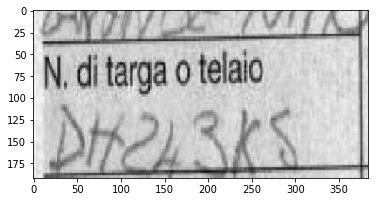

label:  DH243KS


In [12]:
pyplot.imshow(np.reshape(input_image[:, :, :], (y_size, x_size)), cmap=pyplot.get_cmap('gray'))
pyplot.show()
print("label: ", targa)

In [13]:
input_image = np.reshape(input_image, (-1, y_size, x_size, 1))
input_image.shape

(1, 192, 384, 1)

In [14]:
model = load_model('models/model_targhe.h5')

In [15]:
# Define inference models 
#encoder
encoder_inputs_inference = Input(shape=(x_size, y_size, 1), name='input_encoder_inference')
encoder_inference = Model(model.get_input_at(0)[0], model.get_layer("lstm_encoder").output[1:])

#decoder
latent_dim = 512

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_inputs_inference = Input(shape=(1, num_decoder_tokens), name='input_decoder_inference')

decoder_lstm = model.get_layer("lstm_decoder")
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_inference, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

#dense layer
decoder_dense = model.get_layer('time_distributed_dense').layer
decoder_outputs = decoder_dense(decoder_outputs)

#inference
decoder_inference = Model([decoder_inputs_inference] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [16]:
def decode_sequence(input_seq, encoder_inference, decoder_inference, max_decoder_seq_length=7):
    # Encode the input as state vectors.
    states_value = encoder_inference.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['[']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_inference.predict( [target_seq] + states_value )
           
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == ']' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    decoded_sentence = decoded_sentence.replace("]", "")
        
    return decoded_sentence

In [ ]:
decoded_sentence = decode_sequence(input_image, encoder_inference, decoder_inference)
print("gt:", targa)
print("decoded_sentence:", decoded_sentence)